# Zadání

V Edinburghu, stejně jako v dalších městech, funguje systém "bike sharing" - ve městě jsou stanice s koly, člověk si může nějaké půjčit a potom ho vrátit v nějaké další stanici. Problém je, že v některých stanicích se kola pravidelně hromadí a jinde naopak chybí. Provozovatel kol, firma Just Eat Cycles, zadala projekt, jehož cílem je systém zefektivnit. Výstup projektu je otevřený: může to být plán dodávek převážejících kola mezi stanicemi nebo návrh nové cenotvorby.

Coby datový analytik jste součástí týmu, který na projektu pracuje. Vaším úkolem je zpracovat relevantní data a zjistit z nich informace užitečné pro zbytek týmu. Máte k dispozici data o všech výpůjčkách (na ENGETO databázi v tabulce edinburgh_bikes). Proveďte standardní deskriptivní statistiku dat. Také zjistěte minimálně následující informace:

* identifikujte aktivní a neaktivní stanice
* identifikujte nejfrekventovanější stanice
* identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí
* spočítejte vzdálenosti mezi jednotlivými stanicemi
* jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty, zobrazte histogram

*Analýza poptávky:*

* zobrazte vývoj poptávky po půjčování kol v čase
* identifikujte příčiny výkyvů poptávky
* zjistěte vliv počasí na poptávku po kolech (údaje o počasí v Edinburghu jsou v tabulce edinburgh_weather)
* půjčují si lidé kola více o víkendu než během pracovního týdne?

In [82]:
import pandas as pd
#!pip install sqlalchemy
import sqlalchemy
import numpy as np
#!pip install PyMySql
#pip install --upgrade pip
from matplotlib import pyplot as plt
from matplotlib import cm

student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(student_conn_string) #engine kde je databaze
query = "select * from edinburgh_bikes"
df = pd.read_sql(query, alchemy_conn)

In [2]:
#df.info()
df.replace('Picady Place','Picardy Place', inplace=True)
df.replace('Bruntsfield','Bruntsfield links', inplace=True)
df.replace('Brunswick Place','Brunswick Place - Virtual', inplace=True)
df.replace('Meadow Place 2','Meadow Place', inplace=True)
df.head()
# df.loc[df['start_station_id']==1024]

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


# IDENTIFIKUJTE AKTIVNÍ A NEAKTIVNÍ STANICE, IDENTIFIKUJTE NEJFREKVENTOVANĚJŠÍ STANICE


In [3]:
selection = ['start_station_id','start_station_name']
start_stations=(df[selection]
                    .assign(count_start=1)
                    .groupby(['start_station_id', 'start_station_name'])
                    .count()
                    .sort_values('count_start',ascending=False)
                   )
start_stations.index.set_names(['id','name'],inplace=True)
#start_stations.reset_index(level='name',inplace=True)

selection = ['end_station_id','end_station_name']
end_stations=(df[selection]
                    .assign(count_end=1)
                    .groupby(['end_station_id', 'end_station_name'])
                    .count()
                    .fillna(0)
                    .sort_values('count_end',ascending=False)
             )
end_stations.index.set_names(['id','name'],inplace=True)
#end_stations.reset_index(level='name',inplace=True)

# Duplikovaný index
#start_stations[start_stations.index.duplicated()]
#end_stations.loc[[242]]

In [4]:
aktivita = (start_stations
            .join(end_stations, how='outer')
            .assign(total_count = start_stations['count_start']+ end_stations['count_end'])
            .fillna(0)
            .sort_values('total_count', ascending=False)
           )

### Deset nejfrekventovanějších stanic

In [5]:
aktivita.head(10)

,,count_start,count_end,total_count
id,name,,,
265,Meadows East,12715.0,11371.0,24086.0
250,Victoria Quay,8140.0,11479.0,19619.0
1728,Portobello - Kings Road,8036.0,10091.0,18127.0
248,Bristo Square,10999.0,6672.0,17671.0
259,St Andrew Square,10372.0,6943.0,17315.0
262,Canonmills,7589.0,9482.0,17071.0
358,Leith Walk,6554.0,9326.0,15880.0
1024,Meadow Place,7582.0,6127.0,13709.0
289,Castle Street,7628.0,6029.0,13657.0


### Deset nejméně frekventovaných stanic

In [6]:
aktivita.tail(10)

,,count_start,count_end,total_count
id,name,,,
1056,Fort Kinnaird,3.0,6.0,9.0
1057,Pleasance - Edinburgh University Sports Fair,2.0,6.0,8.0
299,Depot Virtual,3.0,5.0,8.0
965,Sustrans - walk cycle event,4.0,3.0,7.0
241,Depot,2.0,3.0,5.0
981,Royal Highland Show - West Gate (19th to 23rd June),1.0,2.0,3.0
1740,Cycling Scotland Conference,1.0,2.0,3.0
1857,City Chambers Launch Station,1.0,0.0,0.0
242,Virtual Depot,0.0,2.0,0.0


# IDENTIFIKUJTE STANICE, NA KTERÝCH SE KOLA HROMADÍ, A STANICE, KDE POTENCIÁLNĚ CHYBÍ

## Stanice, kde se kola nejvíce hromadí

In [7]:
acc = pd.DataFrame(aktivita, columns =['count_start', 'count_end']).assign(bikes_cnt= aktivita.count_end - aktivita.count_start)

In [8]:
acc = acc.sort_values('bikes_cnt', ascending=False).fillna(0)
acc.head(10)

,,count_start,count_end,bikes_cnt
id,name,,,
250,Victoria Quay,8140.0,11479.0,3339.0
358,Leith Walk,6554.0,9326.0,2772.0
1824,Duke Street,5617.0,7961.0,2344.0
1728,Portobello - Kings Road,8036.0,10091.0,2055.0
262,Canonmills,7589.0,9482.0,1893.0
285,Ocean Terminal,5236.0,6991.0,1755.0
258,Stockbridge,5072.0,6779.0,1707.0
257,Portobello,3934.0,5146.0,1212.0
366,Dudley Gardens,1641.0,2574.0,933.0


## Stanice, kde kola chybí

In [9]:
acc.tail(10)

,,count_start,count_end,bikes_cnt
id,name,,,
265,Meadows East,12715.0,11371.0,-1344.0
1024,Meadow Place,7582.0,6127.0,-1455.0
264,Pollock Halls,6076.0,4603.0,-1473.0
289,Castle Street,7628.0,6029.0,-1599.0
1767,Bruntsfield Links,4571.0,2966.0,-1605.0
260,Lauriston Place,5218.0,3014.0,-2204.0
189,City Chambers,4605.0,2223.0,-2382.0
247,Charlotte Square,6834.0,4248.0,-2586.0
259,St Andrew Square,10372.0,6943.0,-3429.0


## Akumulace kol + aktivita stanic

In [10]:
selection = ['start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude']
s_stations=(df[selection]
            .groupby(['start_station_id', 'start_station_name'])
            .mean() #protože u každé výpujčky je lehce odlišná latitude/longitude
            )
s_stations.columns = ['lat', 'long']
s_stations.index.set_names(['id','name'],inplace=True)

selection = ['end_station_id','end_station_name', 'end_station_latitude', 'end_station_longitude']
e_stations=(df[selection]
            .groupby(['end_station_id', 'end_station_name'])
            .mean() 
            )
e_stations.columns = ['lat', 'long']
e_stations.index.set_names(['id','name'],inplace=True)


#stations = pd.concat([e_stations, s_stations], axis=0)

stations = acc[['bikes_cnt']].join(s_stations)
#stations = stations.join(e_stations, lsuffix='e_')

stations

,,bikes_cnt,lat,long
id,name,,,
250,Victoria Quay,3339.0,55.977619,-3.174125
358,Leith Walk,2772.0,55.965040,-3.176686
1824,Duke Street,2344.0,55.969012,-3.167395
1728,Portobello - Kings Road,2055.0,55.957915,-3.118332
262,Canonmills,1893.0,55.962804,-3.196284
...,...,...,...,...
260,Lauriston Place,-2204.0,55.944772,-3.197266
189,City Chambers,-2382.0,55.950109,-3.190258
247,Charlotte Square,-2586.0,55.952335,-3.207101


Text(0, 0.5, 'Zeměpisná šířka')

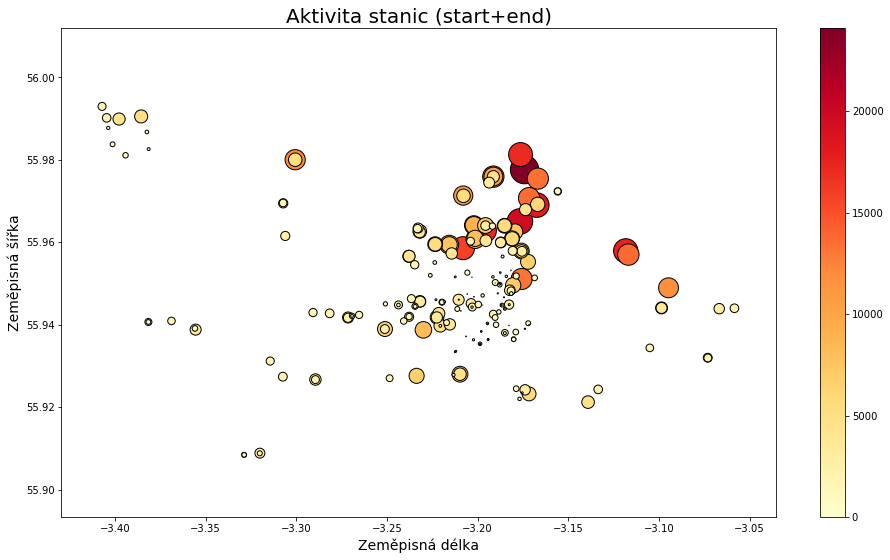

In [79]:


cmap = cm.get_cmap("YlOrRd")

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

stations.plot.scatter('long','lat',  ax=ax, s=(aktivita.total_count/30), c=aktivita.total_count, cmap=cmap, edgecolor='k')
ax.set_title('Aktivita stanic (start+end)', fontsize=20)
ax.set_xlabel('Zeměpisná délka', fontsize=14)
ax.set_ylabel('Zeměpisná šířka', fontsize=14)


# for i in stations.index:
#         ax.text(stations.loc[i, 'long'], stations.loc[i, 'lat'],i)

Text(0, 0.5, 'Zeměpisná šířka')

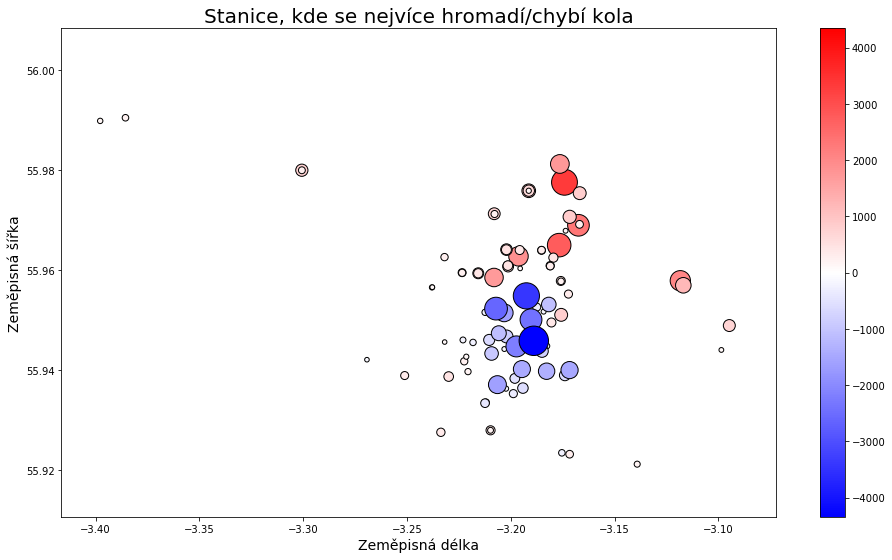

In [77]:
stations_acc = stations.query('abs(bikes_cnt) > 100')

cmap = cm.get_cmap("bwr")

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

stations_acc.plot.scatter('long','lat',  ax=ax, s=(abs(stations_acc.bikes_cnt)/5), c=stations_acc.bikes_cnt, cmap=cmap, vmin=-4350, vmax=4350,edgecolor='k')
ax.set_title('Stanice, kde se nejvíce hromadí/chybí kola', fontsize=20)
ax.set_xlabel('Zeměpisná délka', fontsize=14)
ax.set_ylabel('Zeměpisná šířka', fontsize=14)

# for i in stations_acc.index:
#         ax.text(stations_acc.loc[i, 'long'], stations_acc.loc[i, 'lat'],i)

# SPOČÍTEJTE VZDÁLENOSTI MEZI JEDNOTLIVÝMI STANICEMI

In [164]:
# Výpočet vzdálenosti v km 
def distance(lat1, long1, lat2, long2):
    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return round(km,3)


df_distance = stations[['lat', 'long']]#[0:60]
df_distance = df_distance.sort_index(level=0).reset_index(level=1).dropna()
df_distance = df_distance[~df_distance.index.duplicated(keep='first')]

# Rozšířím tabulku o nové sloupce se jmény indexů
for n, i in enumerate(df_distance.index):
    df_distance.insert(n+3, i, None, True) 

# Vypočtu vzdálenost v kilometrech
for p1 in df_distance.index:
    for p2 in df_distance.index:
        lat1 = df_distance['lat'][p1]
        lat2 = df_distance['lat'][p2]
        long1 = df_distance['long'][p1]
        long2 = df_distance['long'][p2]
        df_distance.at[p1, p2] = distance(lat1,long1,lat2,long2)

df_distance.head(10)


,name,lat,long,171,183,189,225,241,246,247,...,1868,1869,1870,1871,1874,1877,2259,2263,2265,2268
id,,,,,,,,,,,,,,,,,,,,,
171,George Square,55.943084,-3.188311,0,0.967,0.79,0.995,3.831,1.004,1.557,...,14.289,14.434,13.355,13.486,14.001,14.695,2.908,7.565,8.086,1.5
183,Waverley Bridge,55.951591,-3.191603,0.967,0,0.185,0.462,3.207,1.78,0.968,...,13.791,13.923,12.816,13.021,13.526,14.17,2.133,7.816,8.333,0.643
189,City Chambers,55.950109,-3.190258,0.79,0.185,0,0.419,3.272,1.599,1.077,...,13.92,14.054,12.952,13.144,13.651,14.304,2.234,7.716,8.234,0.756
225,Waverley Court,55.951734,-3.184179,0.995,0.462,0.419,0,2.893,1.552,1.428,...,14.229,14.358,13.247,13.464,13.968,14.603,1.915,7.359,7.875,0.549
241,Depot,55.972373,-3.155833,3.831,3.207,3.272,2.893,0,3.876,3.889,...,15.508,15.592,14.426,14.854,15.318,15.791,1.21,6.382,6.834,2.584
246,Royal Commonwealth Pool,55.939000,-3.173924,1.004,1.78,1.599,1.552,3.876,0,2.541,...,15.287,15.434,14.357,14.48,14.996,15.696,3.214,6.692,7.212,2.094
247,Charlotte Square,55.952335,-3.207101,1.557,0.968,1.077,1.428,3.889,2.541,0,...,12.847,12.982,11.884,12.068,12.576,13.234,2.71,8.783,9.301,1.379
248,Bristo Square,55.945896,-3.188912,0.315,0.655,0.476,0.713,3.59,1.207,1.339,...,14.148,14.289,13.199,13.355,13.867,14.545,2.626,7.605,8.126,1.194
249,Fountainbridge,55.943357,-3.209248,1.303,1.429,1.4,1.817,4.63,2.251,1.007,...,13.064,13.217,12.156,12.246,12.765,13.486,3.517,8.868,9.389,2.048


# JAK DLOUHO TRVÁ JEDNA VÝPUJČKA? NAJDĚTE ODLEHLÉ HODNOTY, ZOBRAZTE HISTOGRAM 

In [12]:
'''Duration in minutes'''
dur_mins = pd.DataFrame(df.duration /60)
round(df.duration.describe()/60,2)

count     5683.10
mean        34.35
std        145.06
min          1.02
25%         10.33
50%         19.12
75%         41.87
max      22884.05
Name: duration, dtype: float64

### Detekce odlehlých hodnot pomocí z-score
$$ zs = \frac{x - \mu}{\sigma} $$
Do zs < 3 se vejde 99% všech hodnot, do zs < 2 95% hodnot, do zs < 1 68% hodnot.

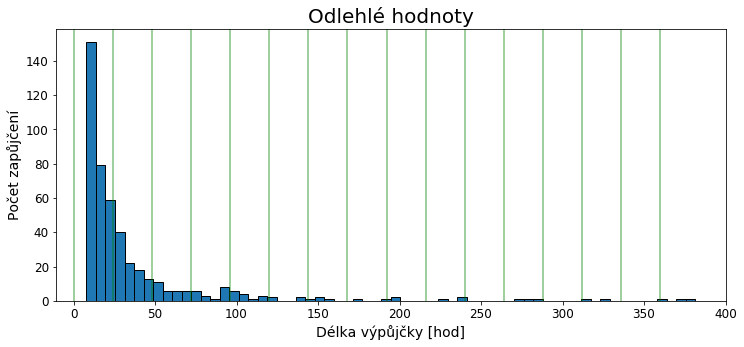

In [13]:
dur_mins['zs']= abs(dur_mins.duration - dur_mins.duration.mean()) / dur_mins.duration.std()
odlehle_hodnoty = dur_mins.query('zs>3').sort_values(by='zs') /60 #převod na hodiny

# Velikost binu
pocet_hodin = 6
x = round(max(odlehle_hodnoty.duration)/pocet_hodin)


fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

odlehle_hodnoty['duration'].plot.hist(bins=x,edgecolor='k', fontsize = 12 )
ax.set_title('Odlehlé hodnoty', fontsize=20)
ax.set_xlabel('Délka výpůjčky [hod]', fontsize=14)
ax.set_ylabel('Počet zapůjčení', fontsize=14)

for i in range(0,round(max(odlehle_hodnoty.duration)/24)):
    ax.axvline(i*24, c='g', alpha = 0.5)


### Nejčastější délka výpůjček
Nejčastěji se kola půjčují na 5-10 minut. Biny mají velikost cca 5 minut, zelené čáry znázorňují hodiny.

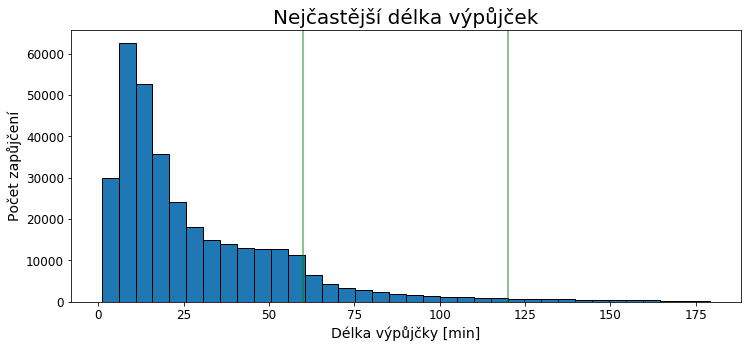

In [14]:
df_vypujcky = dur_mins.query('zs<1').duration

# Velikost binu
pocet_minut = 5
x = round(max(df_vypujcky)/pocet_minut) 

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
df_vypujcky.plot(kind="hist",ax=ax, bins=x, edgecolor='k', fontsize = 12 )
ax.set_title('Nejčastější délka výpůjček', fontsize=20)
ax.set_xlabel('Délka výpůjčky [min]', fontsize=14)
ax.set_ylabel('Počet zapůjčení', fontsize=14)
ax.axvline(60, c='g', alpha = 0.6)
ax.axvline(120, c='green', alpha = 0.6);

# ZOBRAZTE VÝVOJ POPTÁVKY PRO PŮJČOVÁNÍ KOL V ČASE

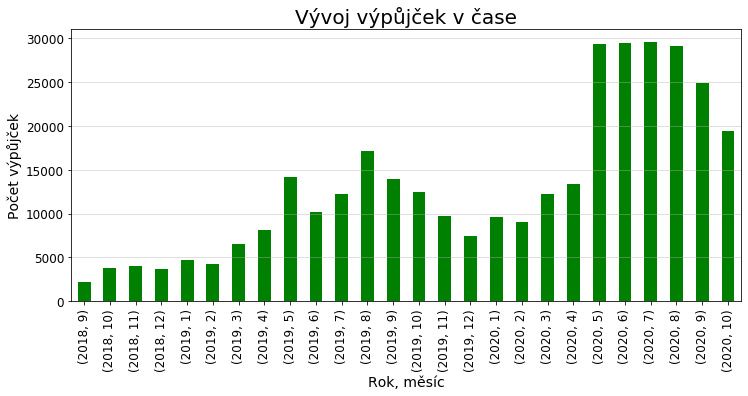

In [325]:
df_cas = df[['started_at']]
df_cas = (df_cas
          .assign(year = pd.DatetimeIndex(df_cas['started_at']).year)
          .assign(month = pd.DatetimeIndex(df_cas['started_at']).month)
          .assign(day = pd.DatetimeIndex(df_cas['started_at']).day)
          .assign(dayofweek = df_cas.started_at.dt.dayofweek)
          .assign(hour = pd.DatetimeIndex(df_cas['started_at']).hour)
          .assign(cnt=1)
         )
df_cas

df2 = df_cas.groupby(['year','month']).count()
jaro = df2.loc[([2018,2019,2020],[3,4,5]), 'cnt']
leto = df2.loc[([2018,2019,2020],[6,7,8]), 'cnt']
podzim = df2.loc[([2018,2019,2020],[9,10,11]), 'cnt']
zima = df2.loc[([2018,2019,2020],[12,1,2]), 'cnt']

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

df_cas.groupby(['year','month']).count().cnt.plot(kind='bar', color='green',  fontsize = 12)
#jaro.plot(kind='bar', color='green')
ax.set_title('Vývoj výpůjček v čase', fontsize=20)
ax.set_xlabel('Rok, měsíc', fontsize=14)
ax.set_ylabel('Počet výpůjček', fontsize=14)
ax.grid(axis='y', alpha=0.5)


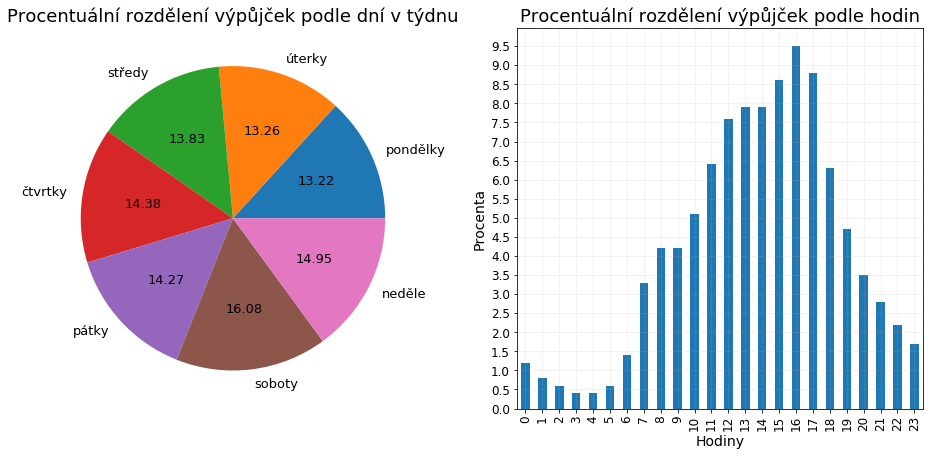

In [277]:
fig = plt.figure(figsize=(16, 7))
pie_kwargs = {'fontsize': 13,  'autopct':'%.2f'}

ax1 = fig.add_subplot(1, 2, 1)
df_cas.groupby(['dayofweek']).count().cnt.plot(kind='pie', labels=['pondělky','úterky','středy','čtvrtky','pátky','soboty','neděle'], ax=ax1, **pie_kwargs)
ax1.set_title('Procentuální rozdělení výpůjček podle dní v týdnu', fontsize=18)
ax1.set_ylabel(' ', fontsize=14)

ax2 = fig.add_subplot(1, 2, 2)
total = df_cas.groupby(['hour']).count().cnt.sum()
round(df_cas.groupby(['hour']).count().cnt/total*100,1).plot(kind='bar',fontsize = 12, ax=ax2)
ax2.set_title('Procentuální rozdělení výpůjček podle hodin', fontsize=18)
ax2.set_xlabel('Hodiny', fontsize=14)
ax2.set_ylabel('Procenta', fontsize=14)
ax2.set_yticks(np.arange(0, 10, 0.5))
ax2.grid(alpha=0.2)



## Počasí

In [327]:
query2 = "select * from edinburgh_weather"
df_weather = pd.read_sql(query2, alchemy_conn)
df_weather

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01
...,...,...,...,...,...,...,...,...,...,...,...
6331,09:00,14 °c,12 °c,21 km/h from SSE,33 km/h,0.4 mm,86%,100%,993 mb,Poor,2020-10-31
6332,12:00,14 °c,12 °c,24 km/h from SSE,37 km/h,0.4 mm,88%,94%,987 mb,Poor,2020-10-31
6333,15:00,10 °c,6 °c,42 km/h from SW,55 km/h,0.5 mm,75%,100%,989 mb,Excellent,2020-10-31
6334,18:00,9 °c,5 °c,38 km/h from WSW,54 km/h,0.0 mm,76%,79%,994 mb,Excellent,2020-10-31
